In [1]:
# Load dependent libraries
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import sys
import sampling
from sampling import ReverseDiffusionPredictor,AnnealedLangevinDynamics
import aapm_sin_ncsnpp_gb as configs
sys.path.append('..')
from losses import get_optimizer
from models.ema import ExponentialMovingAverage
from utils import restore_checkpoint
import models
from models import utils as mutils
from models import ncsnpp
from sde_lib import VESDE


2023-03-23 08:54:32.002284: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Set the model parameters and load the network
ckpt_filename ='./exp/checkpoints/checkpoint_23.pth'
assert os.path.exists(ckpt_filename)
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5
batch_size = 1 
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 

sigmas = mutils.get_sigmas(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer, model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
snr = 0.02734
n_steps =  2
probability_flow = False


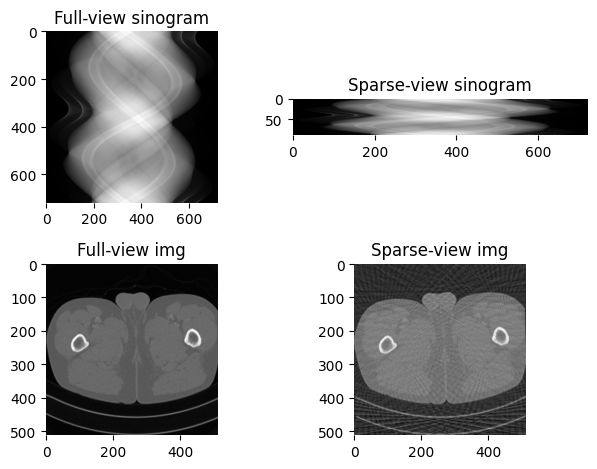

Step: 0   Views:90  PSNR:[ 10.048]
Step: 1   Views:90  PSNR:[ 9.907]
Step: 2   Views:90  PSNR:[ 9.703]
Step: 3   Views:90  PSNR:[ 9.82]
Step: 4   Views:90  PSNR:[ 9.636]
Step: 5   Views:90  PSNR:[ 9.672]
Step: 6   Views:90  PSNR:[ 9.748]
Step: 7   Views:90  PSNR:[ 9.957]
Step: 8   Views:90  PSNR:[ 9.686]
Step: 9   Views:90  PSNR:[ 9.721]
Step: 10   Views:90  PSNR:[ 9.586]
Step: 11   Views:90  PSNR:[ 9.86]
Step: 12   Views:90  PSNR:[ 9.939]
Step: 13   Views:90  PSNR:[ 9.774]
Step: 14   Views:90  PSNR:[ 9.83]
Step: 15   Views:90  PSNR:[ 9.807]
Step: 16   Views:90  PSNR:[ 9.855]
Step: 17   Views:90  PSNR:[ 9.849]
Step: 18   Views:90  PSNR:[ 9.797]
Step: 19   Views:90  PSNR:[ 9.919]
Step: 20   Views:90  PSNR:[ 10.105]
Step: 21   Views:90  PSNR:[ 9.926]
Step: 22   Views:90  PSNR:[ 9.962]
Step: 23   Views:90  PSNR:[ 10.067]
Step: 24   Views:90  PSNR:[ 10.249]
Step: 25   Views:90  PSNR:[ 10.065]
Step: 26   Views:90  PSNR:[ 10.21]
Step: 27   Views:90  PSNR:[ 10.403]
Step: 28   Views:90  PSNR:[

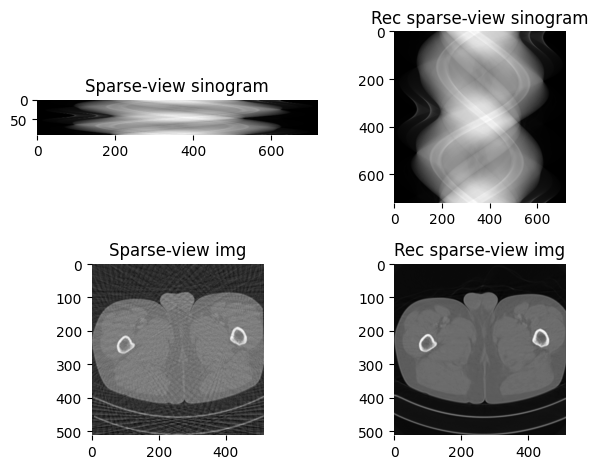

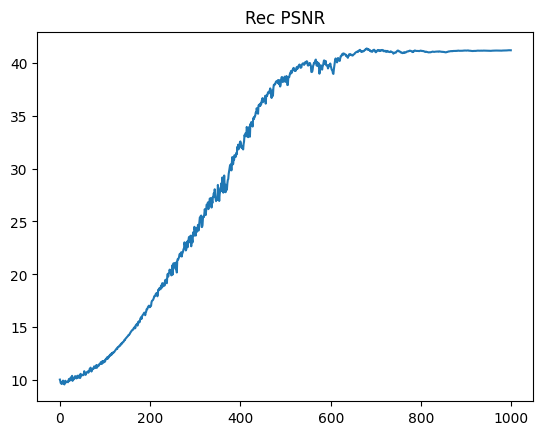

Max PSNR:41.36


In [4]:
# Image reconstruction is under way
import sampling
sampling_fn = sampling.get_pc_sampler(sde, ReverseDiffusionPredictor, AnnealedLangevinDynamics,
                                      None, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

sampling_fn(score_model,32,ReverseDiffusionPredictor,AnnealedLangevinDynamics)
